# Subject Data PreProcessing
* find subject data
* concatenate the inter-session data
* concatenate the intra-session data
* Clean and condense the data
* Create graphs

# TO DO
* DONE - Adapt the cleaning cell to also consider empty data points and mark them as noData in the DataFrame
    * DONE - Make sure that the timestamps are consistent!
    * DONE - Check for possible condition for noData points, e.g. unsufficient eye-openness
    * DONE - Adapt script to rename all colliders to NoHouse that are no house (house list required)
    * DONE - adjust nan dataframes to also add sessions
    * DONE - check for Graffities and replace them with building name
    * IN PROGRESS - Check for Garage Colliders
* DONE - Condense data by replacing identical successive collider hits with (collidername, amount if hits)
    * DONE - confirm that the gaze-noise ratio is correct
* DONE - Account for lost data by interpolation! 
* DONE - Write gaze definition cell by assigning 21 consecutive hits to a gaze caused by an actual fixation. Mark hits<21 as noise 
* DONE - Create unweighted undirected graphs
    * Remove all noHouse hits 
    * Remove all self repetitions 
    * Check the exact procedure 

* IN PROGRESS - Save Subject Data within separate file 
* DONE - Create figure comparison with paper figures 
* IN PROGRESS - Write written summary for P&S of procedure 
* IN PROGRESS - Save graphs 
* IN PROGRESS - Create Centrality Measure Dataframe for all subjects 
* IN PROGRESS - Write Interpolation Variant for 1 sample hits 
* IN PROGRESS - Implement new houselist with name assignments 


## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [4]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap


OG_DATA_PATH = './'
THEORETICAL_DATA_PATH = './Data Exploration/'
THEORETICAL_PROCESSED_DATA_PATH = './Results/'
RESSOURCES_PATH = './Ressources/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/'
GRAPH_DATA_PATH = 'Volumes/EXTENSION/Uni/Study Project/Results/Graphs/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

### Extracting all subject IDs from the data folder

In [45]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1005 1008 1010 1011 1013 1017 1018 1019 1021 1023 1079 1080]


In [2]:
# custom subID
subIDs = [1005]

### Combine the data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [46]:
# --------- Preparation ---------

Session_save_bool = False # set to True if you want to save each individual session as csv
Exploration_save_bool = True # set to True if you want to save the complete exploration as csv
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv
subcount = 0
graffity_replaced_count = 0
removed_body_hits = 0
removed_nohouse_hits = 0

landmarks = ['Castle-TaskBuilding_56',
             'Church-TaskBuilding_16',
             'HighSilo-TaskBuilding_49',
             'Windmill-TaskBuilding_10_1',
             'crane_1',
             'crane_2']

garages_to_stay = ['Garage_185', 
                   'Garage_224', 
                   'Garage_235',  
                   'Garage_86', 
                   'Garage_98']

garages_to_buildings = ['Garage_26', 
                        'Garage_46', 
                        'Garage_71', 
                        'Garage_72']


# column name list for dataframe
col_names =  ['Session',
              'timeStampDataPointStart',
              'timeStampDataPointEnd',
              'hitObjectColliderName', 
              'ordinalOfHit',
              'BitMask',
              'hitPointOnObject.x',
              'hitPointOnObject.y',
              'hitPointOnObject.z',
              'hitObjectColliderBoundsCenter.x',
              'hitObjectColliderBoundsCenter.y',
              'hitObjectColliderBoundsCenter.z',
              'transformed_collidercenter_x',
              'transformed_collidercenter_y'
              'hmdPosition.x',
              'hmdPosition.y',
              'hmdPosition.z']


NoHit_dict = {'hitObjectColliderName': 'NoHit',
              'ordinalOfHit': '1'}


subject_cols = ['SubjectID',
                'Sessions',
                'ET_Sessions',
                'Total Rows Combined',
                'Removed Body Hits', 
                'Removed Graffiti Hits', 
                'Replaced NoHouse Hits',
                'DataLoss BitMask', 
                'DataLoss NoHits',
                'DataLoss Combined']

subject_data_df = pd.DataFrame(columns=subject_cols)

#houselist 
house_file = RESSOURCES_PATH + 'building_renaming_positions.pickle'
try:
    houselist = pd.read_pickle(house_file)
except:
    print('HouseList could not be loaded!')

# --------------------------- MAIN PART ---------------------------


# --------- first layer - subject loop ---------

for subject in subIDs:
    subcount +=1
    print('Subject ' 
          + str(subject) 
          + ' started - ' 
          + str(subcount) 
          + '/' 
          + str(len(subIDs)) 
          + ' subjects')
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject, ignoring OnQuit files
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_Expl_S_') and f.endswith("OnQuit.json") == False], 
                            key=str.lower) 
    
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    # Extract all SubIDs (only one), SessionNumbers, ET_SessionNumbers (and Timestamps)
    try:
        SubID, SessionNumbers, ET_SessionNumbers, UnixTimestamp1, UnixTimeStamp2 = map(list, zip(*folder_files))
    except:
        print('\tSubject ' 
              + str(subject)
              + ' Filename is not valid!')
    
    session_number = int(max(SessionNumbers)) # the maximum session number of the particular subject
    ET_session_number = int(max(ET_SessionNumbers)) # the maximum ET session number of the particular subject
    
    
    # only continue if there are 15 files, aka 5 exploration sessions with 3 ET Sessions each 
    
    if session_number == 5: #and ET_session_number == 3:
    
# --------- second layer - exploration session loop ---------

        # loop over exploration sessions
        for EXP_session in range(session_number):
            # to avoid start at 0
            EXP_session +=1 

            # extract the exploration data
            subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject) + '_Expl_S_' + str(EXP_session)) 
                                   and f.endswith("OnQuit.json") == False], key=str.lower)


            # hitpoint dataframe 
            complete_hitpoints_df = pd.DataFrame(columns = col_names)

            print("\tTotal Sessionfiles: "
                  + str(len(subject_data))
                  + " - Exploration Session "
                  + str(EXP_session))

            s = 0 # session count

    # --------- third layer - eye tracking session loop ---------

            # loop over separate eye tracking sessions
            for ET_session in subject_data:
                s+=1

                # open the JSON file as dictionary
                with open(DATA_PATH + ET_session) as f:
                    try:
                        subject_session = json.loads(f.read())
                    except:
                        print("\tJSON file " + ET_session + " is not valid!")

                hitpoints_df = pd.DataFrame(columns = col_names)
                hitpoint_list = list() # create hitpoint list

                # start timestamp of the session 
                start_time = subject_session['trials'][0]['timeTrialMeasurementStarted']

                # amount of datapoints 
                Len_subses = len(subject_session['trials'][0]['dataPoints'])

                # for loop appending each data point rayCastHit Data
                # afterwards adding the timestamp to the dict 
                # if there is (1) no raycast hit appending NoHit Dict

                # --------------- First order hits! ---------------
                for each in subject_session['trials'][0]['dataPoints']:

                    # ----- account for noHits ----- 
                    if each['rayCastHitsCombinedEyes'] == []:
                        hitpoint_list.append(NoHit_dict)
                        # set index for new entry
                        idx = len(hitpoint_list)-1
                        hitpoint_list[idx]['Session'] = EXP_session
                        hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                        hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                        hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']
                        # hmdPosition
                        hitpoint_list[idx]['hmdPosition.x'] = each['hmdPosition']['x']
                        hitpoint_list[idx]['hmdPosition.y'] = each['hmdPosition']['y']
                        hitpoint_list[idx]['hmdPosition.z'] = each['hmdPosition']['z']

                    else: 
                        # ----- append data point -----
                        hitpoint_list.append(each['rayCastHitsCombinedEyes'][0])
                        # set index for new entry
                        idx = len(hitpoint_list)-1
                        
                        current_collider = hitpoint_list[idx]['hitObjectColliderName']

                        # add new coordinates
                        
                        # add Session, timestamp and bitmask
                        hitpoint_list[idx]['Session'] = EXP_session
                        hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                        hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                        hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']  
                        # hmdPosition
                        hitpoint_list[idx]['hmdPosition.x'] = each['hmdPosition']['x']
                        hitpoint_list[idx]['hmdPosition.y'] = each['hmdPosition']['y']
                        hitpoint_list[idx]['hmdPosition.z'] = each['hmdPosition']['z']


                        # ----- NoHouse Hits -----
                        # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                        if current_collider not in houselist.keys() \
                        and current_collider != 'Body' \
                        and (current_collider.startswith('Graffity_')) == False:
                            hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'
                        # ----- Replace garages -----
                        elif current_collider in garages_to_buildings:
                            garage_number = re.search(r'\d+', current_collider).group()
                            garage_number = str(int(garage_number))
                            
                            new_collider = list(filter(lambda x: x.endswith('_' + garage_number), houselist.keys()))
                            
                            # change coordinates
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.x']
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.y']
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.z']    
                            hitpoint_list[idx]['transformed_collidercenter_x'] = \
                                houselist[new_collider[0]]['transformed_collidercenter_x']
                            hitpoint_list[idx]['transformed_collidercenter_y'] = \
                                houselist[new_collider[0]]['transformed_collidercenter_y']
                            
                        # change remaining coordinates
                        else:
                            try:
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.x']
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.y']
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.z']    
                                hitpoint_list[idx]['transformed_collidercenter_x'] = \
                                    houselist[current_collider]['transformed_collidercenter_x']
                                hitpoint_list[idx]['transformed_collidercenter_y'] = \
                                    houselist[current_collider]['transformed_collidercenter_y']
                            except:
                                pass



             # --------------- Second order hits! ---------------
                    # redo if there is a second ordinal hit
                    try: 
                        # append data point of second raycast hit if it exists
                        hitpoint_list.append(each['rayCastHitsCombinedEyes'][1])
                        # set index for new entry
                        idx = len(hitpoint_list)-1
                        
                        current_collider = hitpoint_list[idx]['hitObjectColliderName']

                        # add Session, timestamp and bitmask
                        hitpoint_list[idx]['Session'] = EXP_session
                        hitpoint_list[idx]['timeStampDataPointStart'] = each['timeStampDataPointStart'] - start_time
                        hitpoint_list[idx]['timeStampDataPointEnd'] = each['timeStampDataPointEnd'] - start_time
                        hitpoint_list[idx]['BitMask'] = each['combinedGazeValidityBitmask']

                        # check for different conditions:

                        # ----- NoHouse Hits -----
                        # check if the collider name is a member of the houselist - if not: rename to NoHouse 
                        if current_collider not in houselist.keys() \
                        and current_collider != 'Body' \
                        and (current_collider.startswith('Graffity_')) == False:
                            hitpoint_list[idx]['hitObjectColliderName'] = 'NoHouse'
                        
                        # ----- Replace garages -----
                        elif current_collider in garages_to_buildings:
                            garage_number = re.search(r'\d+', current_collider).group()
                            garage_number = str(int(garage_number))
                            
                            new_collider = list(filter(lambda x: x.endswith('_' + garage_number), houselist.keys()))
                            
                            # change coordinates
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.x']
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.y']
                            hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                                houselist[new_collider[0]]['ColliderBoundsCenter.z']    
                            hitpoint_list[idx]['transformed_collidercenter_x'] = \
                                houselist[new_collider[0]]['transformed_collidercenter_x']
                            hitpoint_list[idx]['transformed_collidercenter_y'] = \
                                houselist[new_collider[0]]['transformed_collidercenter_y']
                            
                        # change remaining coordinates
                        else:
                            try:
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.x'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.x']
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.y'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.y']
                                hitpoint_list[idx]['hitObjectColliderBoundsCenter.z'] = \
                                    houselist[current_collider]['ColliderBoundsCenter.z']    
                                hitpoint_list[idx]['transformed_collidercenter_x'] = \
                                    houselist[current_collider]['transformed_collidercenter_x']
                                hitpoint_list[idx]['transformed_collidercenter_y'] = \
                                    houselist[current_collider]['transformed_collidercenter_y']
                            except:
                                pass
                            
                        # if the first order hit was a NoHouse hit, but the second was not
                        if hitpoint_list[idx-1]['hitObjectColliderName'] == 'NoHouse' \
                        and hitpoint_list[idx]['hitObjectColliderName'] != 'NoHouse':
                            removed_nohouse_hits += 1

                            hitpoint_list[idx]['ordinalOfHit'] = 1


                            # and remove the first order hit
                            del hitpoint_list[idx-1]

                            idx -= 1 # reset index for safety

                        # ----- Body Hits -----
                        # check if there is a 1 order Body hit, if yes: replace it with second order hit
                        elif hitpoint_list[idx-1]['hitObjectColliderName'] == 'Body':
                            # if second order hit is not a body hit, replace first order hit
                            if hitpoint_list[idx]['hitObjectColliderName'] != 'Body':
                                removed_body_hits += 1

                                hitpoint_list[idx]['ordinalOfHit'] = 1 


                                # and remove the second order hit
                                del hitpoint_list[idx-1]
                                idx -= 1 # reset index for safety

                            # if second order hit is a body hit, replace first order hit with NoHit
                            else:
                                removed_body_hits += 1

                                # replace the first order hit data
                                hitpoint_list[idx-1]['hitObjectColliderName'] = 'NoHit'
                                hitpoint_list[idx-1]['hitPointOnObject.x'] = 'NaN'
                                hitpoint_list[idx-1]['hitPointOnObject.y'] = 'NaN'
                                hitpoint_list[idx-1]['hitPointOnObject.z'] = 'NaN'
                                hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                                hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                                hitpoint_list[idx-1]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                                hitpoint_list[idx-1]['transformed_collidercenter_x'] = 'NaN'
                                hitpoint_list[idx-1]['transformed_collidercenter_y'] = 'NaN'

                                # and remove the second order hit
                                del hitpoint_list[idx]


                    except:
                        pass

                # REMOVING REMAINING GRAFFITY AND BODY HITS
                for index in range(len(hitpoint_list)):
                    if hitpoint_list[index]['hitObjectColliderName'] == 'Body':
                        removed_body_hits += 1
                        hitpoint_list[index]['hitObjectColliderName'] = 'NoHit'
                        hitpoint_list[index]['hitPointOnObject.x'] = 'NaN'
                        hitpoint_list[index]['hitPointOnObject.y'] = 'NaN'
                        hitpoint_list[index]['hitPointOnObject.z'] = 'NaN'
                        hitpoint_list[index]['hitObjectColliderBoundsCenter.x'] = 'NaN'
                        hitpoint_list[index]['hitObjectColliderBoundsCenter.y'] = 'NaN'
                        hitpoint_list[index]['hitObjectColliderBoundsCenter.z'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_x'] = 'NaN'
                        hitpoint_list[idx-1]['transformed_collidercenter_y'] = 'NaN'

                    # check if there are Graffity Hits and rename them as the building they are on
                    if hitpoint_list[index]['hitObjectColliderName'].startswith('Graffity_'):
                        building_number = re.search(r'\d+', hitpoint_list[index]['hitObjectColliderName']).group()
                        graffity_to_building = []


                        # if the number is between 0 and 9, remove the 0
                        building_number = str(int(building_number))

                        for house in houselist.keys():
                            #check if the exact building number is in the houselist to replace graffity name
                            # additionally check that it's not a landmark or a garage to stay
                            if house.endswith('_' + building_number) \
                            and house not in landmarks \
                            and house not in garages:
                                # check if the house name is already in the list
                                if house in graffity_to_building:
                                    pass
                                else:
                                    graffity_to_building.append(house)

                        if len(graffity_to_building) == 1:
                            hitpoint_list[index]['hitObjectColliderName'] = graffity_to_building[0]
                            graffity_replaced_count += 1
                        else:
                            print('Multiple houses with the same number! - Index: ' 
                                  + str(index)
                                  + ', ' 
                                  + str(graffity_to_building))



                # normalize the hitpoint dictionary to get dataframe
                hitpoints_df = pd.json_normalize(hitpoint_list)

                print("\tEXP: " 
                      + str(EXP_session) 
                      + ", ET: " + str(s) 
                      + " normalized - Length: " 
                      + str(len(hitpoints_df)))

                complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)


            
            # --------- Saving each Session ---------

            # If you want to save each session separately, set 'Session_save_bool' to True
            if Session_save_bool == True:
                try:
                    if len(subject_data) > 0:
                        complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH
                                                     + str(subject)
                                                     + "_CompleteSession"
                                                     + str(EXP_session)
                                                     + "_Hitpoints.csv", 
                                                     index=False)
                        print("\t"
                              + str(subject)
                              + " session "
                              + str(EXP_session)
                              + " saved ")
                    else: 
                        print("\t"
                              + str(subject)
                              + " - Session "
                              + str(EXP_session)
                              + " is empty!")
                except:
                    print("\tCould not save subject "
                          + str(subject)
                          + " session "
                          + str(EXP_session)
                          + "!")



            # fill the complete exploration dataframe with the separate session data (combining the sessions)
            complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)

    # --------- Saving the Exploration ---------

        # If you want to save the exploration file, set 'Exploration_save_bool' to True
        if Exploration_save_bool == True:
            # saving the complete exploration
            try:
                complete_exploration_df.to_csv(PROCESSED_DATA_PATH 
                                               + str(subject) 
                                               + "_CompleteExploration_Hitpoints.csv", 
                                                index=False)

                print("\t" + str(subject) + " exploration saved")
            except:
                print("\tCould not save subject " + str(subject) + " exploration data!")


        print("\t" + str(subject) + " - Stats: ")
        print("\tRemoved Body Hits: " 
              + str(removed_body_hits) 
              + ' Removed Graffities: ' 
              + str(graffity_replaced_count) 
              + ' Replaced 1st NoHouse hits: ' 
              + str(removed_nohouse_hits))


        # Some information about the data
        bit_prop = np.sum(complete_exploration_df['BitMask'] != 3) \
            / len(complete_exploration_df)
        noHit_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHit') \
            / len(complete_exploration_df)
        noHouse_prop = np.sum(complete_exploration_df['hitObjectColliderName'] == 'NoHouse') \
            / len(complete_exploration_df)

        print("\tPortion of insufficient data quality (BitMask): " 
              + str("{:.2f}".format(100*bit_prop)) 
              + '%') 
        print("\tNoHits: " 
              + str("{:.2f}".format(100*noHit_prop)) 
              + '%')
        print("\tNoHouse: " 
              + str("{:.2f}".format(100*noHouse_prop)) 
              + '%')
        print("\tTotal missing data: " 
              + str("{:.2f}".format(100*(bit_prop + noHit_prop))) 
              + '%') 
    
    
        # fill the subject info dataframe
        subject_data_df.loc[subcount-1, 'SubjectID'] = subject
        subject_data_df.loc[subcount-1, 'Sessions'] = session_number
        subject_data_df.loc[subcount-1, 'ET_Sessions'] = ET_session_number
        subject_data_df.loc[subcount-1, 'Total Rows Combined'] = len(complete_exploration_df)
        subject_data_df.loc[subcount-1, 'Removed Body Hits'] = removed_body_hits
        subject_data_df.loc[subcount-1, 'Removed Graffiti Hits'] = graffity_replaced_count
        subject_data_df.loc[subcount-1, 'Replaced NoHouse Hits'] = removed_nohouse_hits
        subject_data_df.loc[subcount-1, 'DataLoss BitMask'] = bit_prop
        subject_data_df.loc[subcount-1, 'DataLoss NoHits'] = noHit_prop
        subject_data_df.loc[subcount-1, 'DataLoss Combined'] = bit_prop + noHit_prop
    

    
    # Else exception if the subject data is not complete
    else:
        print('Subject ' 
              + str(subject) 
              + ' has {} Sessions and {} Eye Tracking Sessions'.format(session_number, ET_session_number) 
              + '!')

# If wanted, save the subject information 
if Subject_Info_save_bool == True:
    try:
        subject_data_df.to_csv(PROCESSED_DATA_PATH 
                                       + "Subject_Data.csv", 
                                        index=False)

        print("Subject Data saved")
    except:
        print("Could not save subject data!")
        
              
              
print('Done')

Subject 1005 started - 1/12 subjects
	Total Sessionfiles: 3 - Exploration Session 1
	EXP: 1, ET: 1 normalized - Length: 112825
	EXP: 1, ET: 2 normalized - Length: 116639
	EXP: 1, ET: 3 normalized - Length: 115089
	Total Sessionfiles: 3 - Exploration Session 2
	EXP: 2, ET: 1 normalized - Length: 112574
	EXP: 2, ET: 2 normalized - Length: 110534
	EXP: 2, ET: 3 normalized - Length: 113598
	Total Sessionfiles: 3 - Exploration Session 3
	EXP: 3, ET: 1 normalized - Length: 112756
	EXP: 3, ET: 2 normalized - Length: 116218
	EXP: 3, ET: 3 normalized - Length: 109903
	Total Sessionfiles: 3 - Exploration Session 4
	EXP: 4, ET: 1 normalized - Length: 114298
	EXP: 4, ET: 2 normalized - Length: 115273
	EXP: 4, ET: 3 normalized - Length: 114570
	Total Sessionfiles: 3 - Exploration Session 5
	EXP: 5, ET: 1 normalized - Length: 111347
	EXP: 5, ET: 2 normalized - Length: 111123
	EXP: 5, ET: 3 normalized - Length: 114144
	1005 exploration saved
	1005 - Stats: 
	Removed Body Hits: 53805 Removed Graffitie

	EXP: 5, ET: 3 normalized - Length: 116792
	EXP: 5, ET: 4 normalized - Length: 111342
	1021 exploration saved
	1021 - Stats: 
	Removed Body Hits: 352754 Removed Graffities: 546957 Replaced 1st NoHouse hits: 714416
	Portion of insufficient data quality (BitMask): 1.36%
	NoHits: 1.69%
	NoHouse: 57.42%
	Total missing data: 3.05%
Subject 1023 started - 10/12 subjects
	Total Sessionfiles: 3 - Exploration Session 1
	EXP: 1, ET: 1 normalized - Length: 110595
	EXP: 1, ET: 2 normalized - Length: 111481
	EXP: 1, ET: 3 normalized - Length: 113923
	Total Sessionfiles: 3 - Exploration Session 2
	EXP: 2, ET: 1 normalized - Length: 112877
	EXP: 2, ET: 2 normalized - Length: 119192
	EXP: 2, ET: 3 normalized - Length: 117569
	Total Sessionfiles: 3 - Exploration Session 3
	EXP: 3, ET: 1 normalized - Length: 117326
	EXP: 3, ET: 2 normalized - Length: 117707
	EXP: 3, ET: 3 normalized - Length: 114256
	Total Sessionfiles: 3 - Exploration Session 4
	EXP: 4, ET: 1 normalized - Length: 116422
	EXP: 4, ET: 2 n

### Condense the data and create gaze lists
* Do Runlength Encoding on the colliderName column to reduce the data size

### Interpolation of the data to minimize cut clustering (based on Walter, 2021)
* Interpolation criteria:
    * there are <=21 consecutive NoHit Samples
    * they are surrounded by two clusters on the same collider

In [47]:
# --------- Preparation ---------
RLE_save_bool = False # if you want to save the condensed dataframe
Interpolation_save_bool = True # if you want to save the condensed dataframe
Subject_Info_save_bool = True # set to True if you want to save the subject data as csv

# column names for the condensed df
condense_col_names = ['Session', 
                      'ColliderName',
                      'Samples',]

# column names for the interpolation df
interpol_col_names = ['ColliderName',
                      'Samples',
                      'Index']

subcount = 0 # count subjects


# open the subject data csv
with open(PROCESSED_DATA_PATH + "Subject_Data.csv") as f:
    try:
        subject_data_df = pd.read_csv(f)
    except:
        print("Subject Data file could not be loaded!")



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_CompleteExploration_Hitpoints')], key=str.lower)
    
    if len(subject_folder) != 0:
    
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                data = pd.read_csv(f)
            except:
                print("\tCSV file " + subject_folder[0] + " is not valid!")
    else:
        print('Subject ' + str(subject) + 'has no data file!')
        continue 
           
    data = data[data.ordinalOfHit==1]
    data.reset_index(inplace=True, drop=False)
    
    
    
    # --------- CONDENSE PART ---------
    # dataframe for counting successive appearances
    condense_df = pd.DataFrame(index=range(len(data)), columns=condense_col_names)
    condense_df.Session = data.Session
    condense_df.ColliderName = data.hitObjectColliderName
    # count successive appearances by comparing with shifted df + cumsum + cumcount
    condense_df['Samples'] = \
    data['hitObjectColliderName'].groupby((data['hitObjectColliderName'] 
                                           != data['hitObjectColliderName'].shift()).cumsum()).cumcount() + 1

    
    # use the condense_df to sum up unique countings
    condense_count = (data['hitObjectColliderName'] != data['hitObjectColliderName'].shift()).cumsum()
    ColliderNames_df = pd.DataFrame()
    Samples_df = pd.DataFrame()

    # find the respective collidername by searching for the first (and possibly only) appearance
    ColliderNames_df['ColliderName'] = condense_df[condense_df.Samples==1].ColliderName
    ColliderNames_df.reset_index(inplace=True, drop=True)
    # count the actual successive appearances by grouping by the unique countings in condense_count
    Samples_df['Samples'] = condense_df.groupby(condense_count).ColliderName.count()
    Samples_df.reset_index(inplace=True, drop=True)

    
    # join the Dataframes 
    condense_RLE_df = ColliderNames_df.join(Samples_df)
    
    
    # --------- INTERPOLATION PART ---------
    condense_data = condense_RLE_df.copy() #copy for safety
    
    current_collider = 'X' # the reference collidername for interpolation
    last_hits = 0 # the reference hit sum for interpolation 
    
    interpolated_data = pd.DataFrame(columns=interpol_col_names) # create empty df for interpolation
    
    # loop through the condense dataframe and search for the following conditions:
    # 1. ColliderName is 'NoHit' and the Sample Size is <=21: add the sample size to the sample variable
    # 2. ColliderName is 'NoHit' and the Sample Size is >21: append the NoHit Row to the new Interpolation df
    # 3. ColliderName is NOT the current collider: append the Row to the new Interpolation df 
    #    and set to current collider
    # 4. ColliderName IS the current collider: add the sample size to the collider row in the interpolation df
    
    for index, collider in enumerate(condense_data.ColliderName):
        print("\tInterpolation Status: " + str("{:.1f}".format(100*index/len(condense_data))) + '%', end="\r")

        if collider == 'NoHit': # we need to check also for the current collidername 
            if condense_data.Samples[index] <= 21:
                last_hits += condense_data.Samples[index]
            else:
                interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
                interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
                last_hits = 0
                current_collider = 'X'

        elif collider != current_collider:
            if last_hits > 0:
                interpolated_data = interpolated_data.append({'ColliderName': 'NoHit',\
                                                              'Samples': last_hits,\
                                                              'Index': index-1}, \
                                                              ignore_index=True)
                
                
            interpolated_data = interpolated_data.append(condense_data.iloc[[index]], ignore_index=True)
            interpolated_data.loc[len(interpolated_data)-1, 'Index'] = index
            last_hits = 0
            current_collider = condense_data.ColliderName[index]
        else:
            interpolated_data.loc[len(interpolated_data)-1, 'Samples'] += last_hits + condense_data.Samples[index]
            last_hits = 0

    
    removed_hits = len(condense_data) - len(interpolated_data)
    prop = removed_hits/len(condense_data)
    
    
    if removed_hits != len(condense_data):
        print("\tInterpolation successful! - Removed rows: " 
              + str(removed_hits) 
              + ', ' 
              + str("{:.1f}".format(100*prop))
              + '%')
    else:
        print('Something went wrong with the interpolation')
    
    
    
    # --------- SAVING ---------
    # If you want to save the exploration file, set 'RLE_save_bool' to True
    if RLE_save_bool == True:
        # saving the condensed dataframe
        try:
            condense_RLE_df.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_condense_RLE_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
    if Interpolation_save_bool == True:
        # saving the interpolation dataframe
        try:
            interpolated_data.to_csv(PROCESSED_DATA_PATH 
                                           + str(subject) 
                                           + "_interpolation_df.csv", 
                                            index=False)
            
            print("\t" + str(subject) + " dataframe saved")
        except:
            print("\tCould not save subject " + str(subject) + " interpolation dataframe!")
            
    
    # fill the subject data df
    sub_loc = subject_data_df[subject_data_df['SubjectID'] == subject].index[0]
    subject_data_df.loc[sub_loc, "Condensed Size"] = len(interpolated_data)
    subject_data_df.loc[sub_loc, "Removed rows"] = removed_hits
    subject_data_df.loc[sub_loc, "Removed rows (%)"] = prop
    
    
if Subject_Info_save_bool == True:
    # saving the subject info dataframe
    try:
        subject_data_df.to_csv(PROCESSED_DATA_PATH
                                       + "Subject_Data.csv", 
                                        index=False)

        print("Subject Info dataframe saved")
    except:
        print("\tCould not save subject " + str(subject) + " interpolation dataframe!")
        
    
    

print('Done')

Subject 1005 started - 1/12
	Interpolation successful! - Removed rows: 5104, 9.2%
	1005 dataframe saved
Subject 1008 started - 2/12
	Interpolation successful! - Removed rows: 4784, 7.7%
	1008 dataframe saved
Subject 1010 started - 3/12
	Interpolation successful! - Removed rows: 5776, 9.3%
	1010 dataframe saved
Subject 1011 started - 4/12
	Interpolation successful! - Removed rows: 3834, 8.0%
	1011 dataframe saved
Subject 1013 started - 5/12
	Interpolation successful! - Removed rows: 5094, 8.7%
	1013 dataframe saved
Subject 1017 started - 6/12
	Interpolation successful! - Removed rows: 3138, 7.4%
	1017 dataframe saved
Subject 1018 started - 7/12


IndexError: list index out of range

In [40]:
# open the JSON file as dictionary
with open(PROCESSED_DATA_PATH + '1023_interpolation_df.csv') as f:
    try:
        interpolated_data = pd.read_csv(f)
    except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
# open the JSON file as dictionary
with open(PROCESSED_DATA_PATH + '1023_Condense_RLE_df.csv') as f:
    try:
        condense_RLE_df = pd.read_csv(f)
    except:
            print("\tCould not save subject " + str(subject) + " condensed dataframe!")
            
            

In [38]:
test = data.copy()
test = test[test.ordinalOfHit == 1]

expl_len = len(test)
expl_nohouse_len = len(test[test.hitObjectColliderName == 'NoHouse'])
condense_len = condense_RLE_df.Samples.sum()
condense_nohouse_len = condense_RLE_df[condense_RLE_df.ColliderName=='NoHouse'].Samples.sum()


print('Expl len: ' + str(expl_len) + ' Expl_NoHouse_len: ' + str(expl_nohouse_len))
print('Condense len: ' + str(condense_len) + ' Condense_NoHouse_len: ' + str(condense_nohouse_len))


Expl len: 1012775 Expl_NoHouse_len: 534057
Condense len: 1012775 Condense_NoHouse_len: 534057


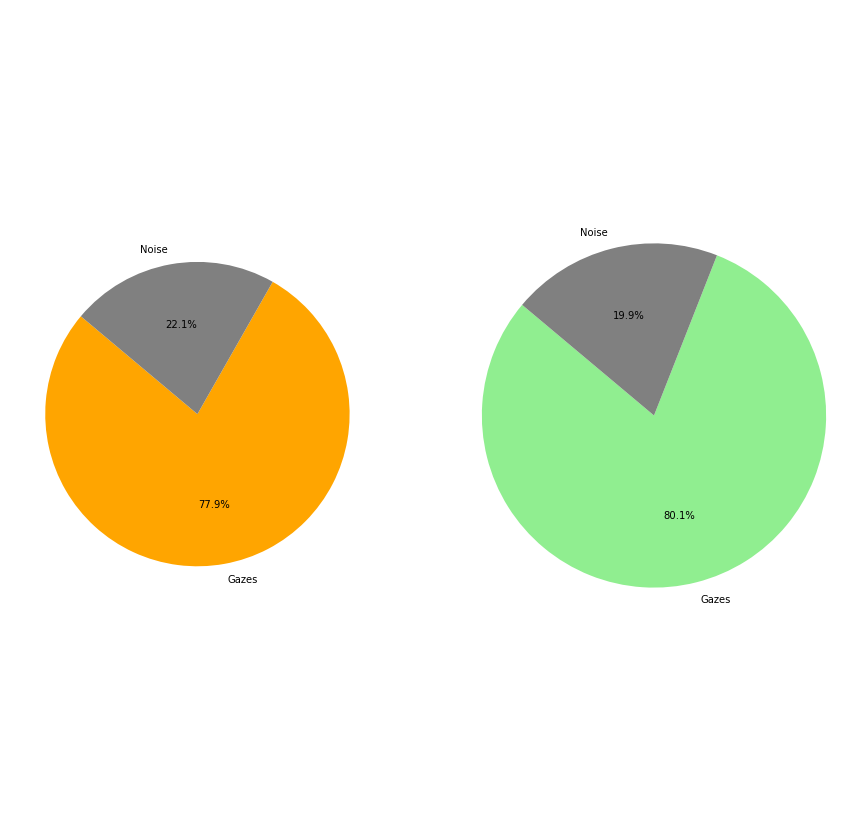

In [39]:
gazes = condense_RLE_df[condense_RLE_df.Samples>21].Samples.sum()
noise = condense_RLE_df[condense_RLE_df.Samples<21].Samples.sum()

gazes_interpolated = interpolated_data[interpolated_data.Samples>21].Samples.sum()
noise_interpolated = interpolated_data[interpolated_data.Samples<21].Samples.sum()



# Data to plot
labels = 'Gazes', 'Noise'
sizes = [gazes, noise]
colors = ['orange', 'gray']
explode = (0, 0, 0, 0)  # explode 1st slice

# Data to plot after interpolation
labels_interpolated = 'Gazes', 'Noise'
sizes_interpolated = [gazes_interpolated, noise_interpolated]
colors_interpolated = ['lightgreen', 'gray']
explode_interpolated = (0, 0, 0, 0)  # explode 1st slice


# Plot
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.subplot(1,2,2)
plt.pie(sizes_interpolated, labels=labels_interpolated, colors=colors_interpolated,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

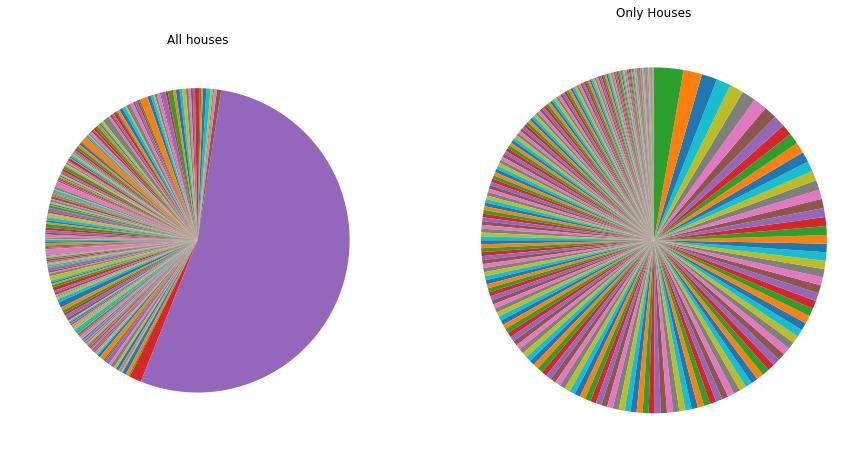

In [40]:
ColliderAppearances = interpolated_data.groupby('ColliderName').Samples.sum()

Colliders_onlyHouses = ColliderAppearances.copy()
Colliders_onlyHouses = Colliders_onlyHouses.drop(labels=['NoHouse'])
Colliders_onlyHouses = Colliders_onlyHouses.sort_values()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.pie(ColliderAppearances, shadow=False, startangle=140)
plt.title('All houses')
plt.subplot(1,2,2)
plt.pie(Colliders_onlyHouses, shadow=False, startangle=90)
plt.title('Only Houses')

plt.axis('equal')
plt.show()

In [41]:
ColliderAppearances.sort_values()[-20:-1]

ColliderName
Building_162                 3943
HighSilo-TaskBuilding_49     4035
TaskBuilding_25              4124
Building_94                  4338
TaskBuilding_40              4348
TaskBuilding_14              4428
TaskBuilding_1               4595
Building_198                 4707
Building_91                  4808
TaskBuilding_29              4845
TaskBuilding_19              5157
TaskBuilding_27              5679
Building_210                 5946
Building_136                 6073
Building_176                 6108
church                       6434
TaskBuilding_50              6813
TaskBuilding_35              8171
NoHit                       12889
Name: Samples, dtype: int64

In [145]:
sorted_interpolation = interpolated_data.groupby('ColliderName').Samples.sum().sort_values()

building14distance = (sorted_interpolation['TaskBuilding_14'] - sorted_interpolation[0:-1].mean()) / sorted_interpolation[0:-1].std()

print('The most viewed building after interpolation is currently {} sigma away from the mean!'.format(building14distance))


The most viewed building after interpolation is currently 4.049515232990687 sigma away from the mean!


(array([0.15650851, 0.02979381, 0.02094636, 0.01105005, 0.01294417,
        0.00870554, 0.0073667 , 0.00654612, 0.00754563, 0.0046335 ,
        0.00379441, 0.00322679, 0.00305404, 0.00319594, 0.00210389,
        0.0017954 , 0.00163499, 0.00180774, 0.00147457, 0.00124629,
        0.00099333, 0.00104886, 0.00124629, 0.0007342 , 0.00077739,
        0.00082058, 0.00105503, 0.00064783, 0.00057996, 0.00061081,
        0.01211125]),
 array([1.0, 4.225806451612903, 7.451612903225806, 10.677419354838708,
        13.903225806451612, 17.129032258064516, 20.354838709677416,
        23.58064516129032, 26.806451612903224, 30.032258064516128,
        33.25806451612903, 36.483870967741936, 39.70967741935483,
        42.93548387096774, 46.16129032258064, 49.387096774193544,
        52.61290322580645, 55.83870967741935, 59.064516129032256,
        62.29032258064516, 65.51612903225806, 68.74193548387096,
        71.96774193548387, 75.19354838709677, 78.41935483870967,
        81.64516129032258, 84.870967

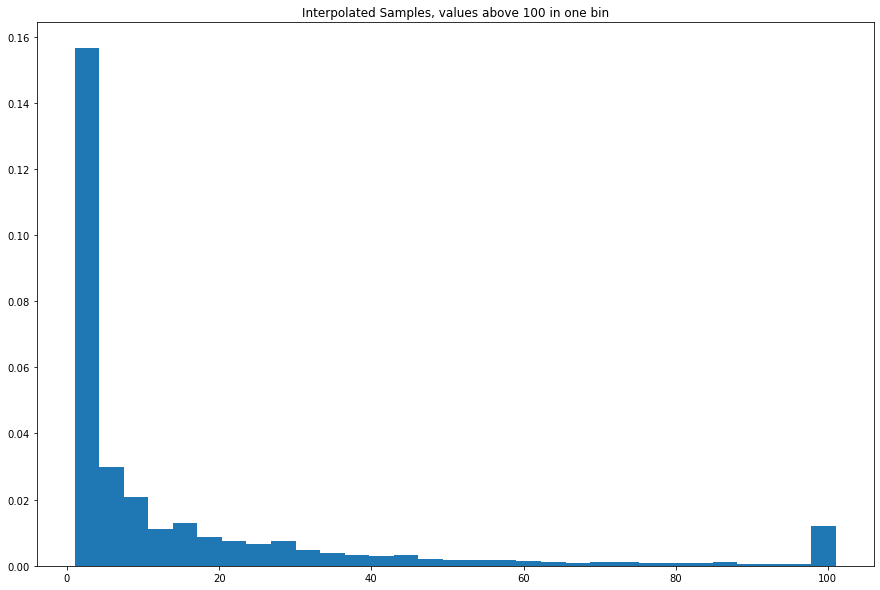

In [42]:
interpolation_til_100 = interpolated_data.copy()
interpolation_til_100 = interpolation_til_100.Samples
interpolation_til_100[interpolation_til_100>100] = 101

plt.figure(figsize=(15,10))
#plt.subplot(2,1,1)
#plt.title('Interpolated Samples, all')
#plt.hist(interpolated_data.Samples, density=True)
#plt.subplot(2,1,2)
plt.title('Interpolated Samples, values above 100 in one bin')
plt.hist(interpolation_til_100, bins= 31, density=True)

## Graph Creation
* The graph creation involves the following steps:
    * creating the edge list
        * Remove non Fixations (SampleSize <= 21) 
        * Remove all noHouse hits 
        * Remove all noHit hits 
        * Remove all self repetitions
        * Shift the edgelist by one row and create chronology 
    * Use NetworkX to build the graph
    * Plot the graph onto the city map (using map coordinates)

In [43]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
EdgeList_save_bool = True # if you want to save the edge list 
Graph_save_bool = True # if you want to save the graph as a networkx graph
Graph_save_img_bool = True # if you want to save the graph as an image
plot_edges_bool = False # if you want to plot the graph's edges

subcount = 0 # count subjects

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")



# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in PROCESSED_DATA_FOLDER 
                             if f.startswith(str(subject)+'_interpolation_df')], key=str.lower)
    
    if subject_folder != []:
        # open the JSON file as dictionary
        with open(PROCESSED_DATA_PATH + subject_folder[0]) as f:
            try:
                interpolated_data = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " interpolation dataframe!")

        edge_list = pd.DataFrame(columns=['Edge1','Edge2'])



        # --------- EDGE LIST CREATION ---------

        # filter out Clusters with <=21 hits, 'NoHouse' hits, 'NoHit' hits and self repititions (with unique)
        transition = interpolated_data[interpolated_data.Samples>21]
        transition = transition[transition.ColliderName!='NoHouse']
        transition = transition[transition.ColliderName!='NoHit']
        unique_count = transition.ColliderName.groupby((transition['ColliderName'] 
                                                != transition['ColliderName'].shift()).cumsum()).cumcount() + 1

        # Assign filtered gaze hits to the edge list 
        edge_list.Edge1 = transition[unique_count==1].ColliderName
        edge_list.reset_index(inplace=True, drop=True)

        # shift the gaze hits by one and add the last entry of Edge1 to the first of Edge 2
        edge_list.Edge2[1:len(edge_list)-1] = edge_list.Edge1[0:len(edge_list)-2]
        edge_list.loc[0, 'Edge2'] = edge_list.Edge1[len(edge_list)-1]
        edge_list.loc[len(edge_list)-1, 'Edge2'] = edge_list.Edge1[0]

        # --------- GRAPH CREATION ---------

        # create graph from edgelist
        G = nx.Graph()
        G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')


        # Setting the node coordinates of each node of the graph

        #load the house coordinates file 
        housecoords_file = RESSOURCES_PATH + 'buildings_nonunique_positions.pickle'
        try:
            housecoords = pd.read_pickle(housecoords_file)
        except:
            print('\tHouseList could not be loaded!')


        # node list
        nodelist = list(G.nodes)

        # coord dict
        node_pos = {}

        for node in nodelist:
            # currently: Special case for cranes - will change
            if node.startswith('crane_'):
                node_pos[node] = (0,0)
            else:
                # assign node coordinates
                x = list(housecoords[housecoords.BuildingName == node].transformed_buildingposition_x)[0]
                y = list(housecoords[housecoords.BuildingName == node].transformed_buildingposition_y)[0]
                node_pos[node] = (x,y) 

        # set the graph's node coordinates attribute
        nx.set_node_attributes(G, node_pos, 'coord')


        # --------- ANALYSIS ---------

        # create degree list of the graph 

        degree_df = (pd.DataFrame(list(G.degree), columns=['node','degree']).set_index('node'))


        mean_degree = np.mean(degree_df['degree'])
        std_degree = np.std(degree_df['degree'])
        max_degree = max(degree_df['degree'])

        print('\tMean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
        print('\tMaxmimum Degree of ' 
              + str("{:.2f}".format(max_degree)) 
              + ' is ' +
              "{:.2f}".format((max_degree-mean_degree)/std_degree)
              + ' sigma away from the mean')




        # --------- PLOTTING ---------    

        if Plotting_bool == True:

            # plot the map
            fig = plt.figure(figsize=(20,15))
            ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
            plt.title("Graph on Map - Subject " + str(subject))
            plt.xlim(0, 4096)
            plt.ylim(0, 4096)
            ax.set_frame_on(False)
            plt.axis('off')
            plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                     extent= ax.get_xlim() + ax.get_ylim(),
                     zorder=1, alpha=0.8)

            # Draw the graph 
            vmin = degree_df['degree'].min()
            vmax = degree_df['degree'].max()

            nx.draw_networkx_nodes(G,
                                   node_pos, 
                                   alpha = 1, 
                                   node_size = 100, 
                                   node_color=degree_df['degree'], 
                                   cmap=parula_map)

            if plot_edges_bool == True:
                nx.draw_networkx_edges(G, 
                                       node_pos, 
                                       edge_color='k', 
                                       alpha=0.5, 
                                       width=1,
                                       style='dashed')


            # subgraph for highlighting single nodes
            #building = 'Building_176'
            #nx.draw_networkx(G.subgraph(building), node_color=degree_df[building], pos=node_pos, node_size=200)


            sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm.set_array([])
            cbar = plt.colorbar(sm)


        # --------- SAVING ---------
        
        # save the edge list 
        if EdgeList_save_bool == True:
            # saving the subject info dataframe
            try:
                edge_list.to_csv(GRAPH_DATA_PATH
                                + str(subject)
                                + "edgelist.csv", 
                                index=False)

                print("\tEdge list saved")
            except:
                print("\tCould not save subject " + str(subject) + " edge list!")

        
        
        # save the graph 
        if Graph_save_bool == True:
            # saving the subject info dataframe
            try:
                nx.write_gexf(G, GRAPH_DATA_PATH + str(subject) + '_Graph')

                print("\tGraph saved")
            except:
                print("\tCould not save subject " + str(subject) + " Graph!")

        # save the graph as png 
        if Graph_save_img_bool == True:
            # saving the subject info dataframe
            try:
                plt.savefig(GRAPH_DATA_PATH + str(subject) + "_Graph.png", format="PNG")

                print("\tGraph saved")
            except:
                print("\tCould not save subject " + str(subject) + " Graph!")
                
        
    
    else:
        print("Subject " 
              + str(subject)
              + ' does not exist in the folder!')
        
        
print('Done')
    

Subject 1005 started - 1/1


IndexError: list index out of range

In [57]:
edge_list.to_csv(GRAPH_DATA_PATH
                + str(subject)
                + "edgelist.csv", 
                index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'Volumes/EXTENSION/Uni/Study Project/Results/Graphs/1023edgelist.csv'

In [ ]:
/Volumes/EXTENSION/Uni/Study Project/Results/Graphs

In [101]:
node_pos[building]

(1793.5104740477652, 2737.349510396564)

In [103]:
housecoords[housecoords.BuildingName==building]

,BuildingID,BuildingName,BuildingPosition.x,BuildingPosition.y,BuildingPosition.z,BuildingRotation.x,BuildingRotation.y,BuildingRotation.z,buildingRotationQuaternion.x,buildingRotationQuaternion.y,buildingRotationQuaternion.z,buildingRotationQuaternion.w,BuildingDirection.x,BuildingDirection.y,BuildingDirection.z,transformed_buildingposition_x,transformed_buildingposition_y
52,176,Building_176,-61.66,0.56,167.100006,270.0,154.860931,0.0,-0.153884,0.690159,0.690159,0.153884,7.450581e-08,1.0,-2.458692e-07,1793.510474,2737.34951


In [80]:
edge_list.groupby('Edge1').count().sort_values(by='Edge2', ascending=False)[:15]

,Edge2
Edge1,
Building_176,65
Building_94,63
TaskBuilding_35,55
Building_198,52
TaskBuilding_40,52
Building_113,51
TaskBuilding_14,50
Building_203,47
Building_229,46


In [76]:
degree_df#.sort_values('degree', ascending=False)

,degree
node,
Building_161,18
Building_145,23
TaskBuilding_5,18
Building_151,12
TaskBuilding_27,28
...,...
Building_95,3
Building_191,2
Building_223,10


NameError: name 'first_G' is not defined

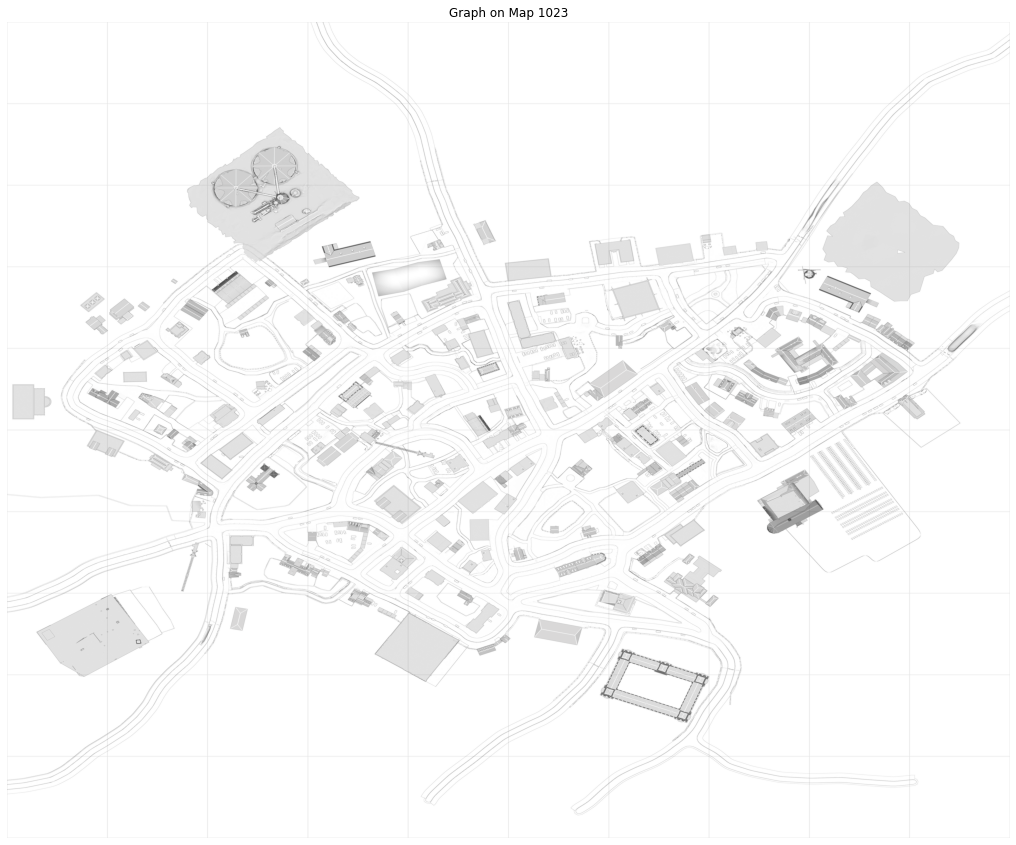

In [44]:
# load images
white_bg_img = cv2.imread("./ressources/map_white.png")

# plot
fig = plt.figure(figsize=(20,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Graph on Map 1023")
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.8)

#nx.draw_networkx_nodes(G = first_G, pos = node_pos, alpha = 1, node_size = 100, node_color=degree_values)
#nx.draw_networkx_edges(first_G, node_pos, edge_color='k', alpha=0.5, width=1)

#nx.draw(first_G, node_pos,node_size=100, style='dashed', node_color=degree_values)

degree_df = (pd.DataFrame(list(first_G.degree), columns=['node','degree']).set_index('node'))
vmin = degree_df['degree'].min()
vmax = degree_df['degree'].max()
cmap = parula_map

nx.draw_networkx(first_G,
                 pos=node_pos,
                 node_size=100,
                 with_labels=False,
                 style='dashed',
                 node_color=degree_df['degree'],
                 cmap=cmap)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

Text(0, 0.5, 'Frequency')

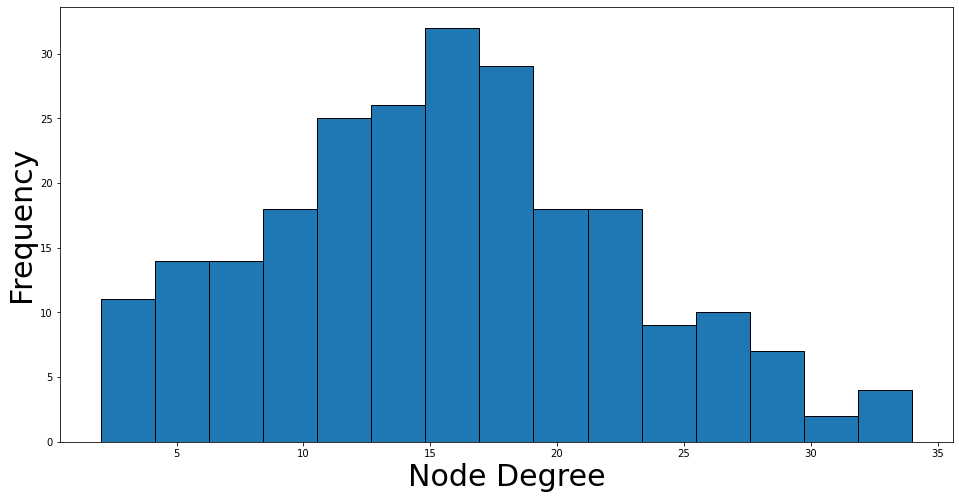

In [14]:
plt.figure(figsize=(16,8))
plt.hist(degree_values, bins=15, ec='black')
plt.xlabel("Node Degree", fontsize=30)
plt.ylabel("Frequency", fontsize=30)


In [15]:
mean_degree = np.mean(degree_values)
std_degree = np.std(degree_values)
max_degree = max(degree_values)

print('Mean/Std Degree: ' + str("{:.2f}".format(mean_degree)) + '/' + str("{:.2f}".format(std_degree)))
print('Maxmimum Degree of ' 
      + str("{:.2f}".format(max_degree)) 
      + ' is ' +
      "{:.2f}".format((max_degree-mean_degree)/std_degree)
      + ' sigma away from the mean')



Mean/Std Degree: 15.54/6.93
Maxmimum Degree of 34.00 is 2.66 sigma away from the mean
